<a href="https://colab.research.google.com/github/kb21032001/Bird_audio_classifier_Resnet/blob/main/Bird_Resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
import os
import random
import pandas as pd
from IPython.display import Audio
import IPython
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.functional import normalize
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
from torchvision import models
import torchaudio
import torchaudio.transforms as a_T
import torchvision.transforms as v_T
import librosa
import matplotlib.pyplot as plt
import numpy as np
import scipy
from skimage.restoration import denoise_wavelet
import pandas as pd
import warnings
import random

In [43]:
# from google.colab import drive
# drive.mount('/content/drive')

In [44]:
random.seed(1)
torch.random.manual_seed(1)
torch.manual_seed(1)

In [45]:
dataset_path = "C:\\Users\\KB\\Documents\\ECE496_capstone\\venv\\Scripts\\birdclef-2022\\train_audio"
class Species:
    def __init__(self, name, recordings):
        self.name = name
        self.recordings = recordings
        self.len = len(self.recordings)

    def set_label(self, label):
        #Label of a specie based on the number of recrdings the dataset has
        self.label = label

    def compute_len(self):
        self.len = len(self.recordings)

    def __repr__(self):
        return '{' + 'Name:' + self.name + ', ' + 'No. Recs:' + str(self.len) + ', ' + 'Label:' + str(self.label) + '}'

def get_spectrogram(wave: torch.Tensor, sample_rate=16000, n_fft=1024, hop_length=512, n_mels=40):
  mel_spectrogram = a_T.MelSpectrogram(sample_rate, n_fft, hop_length, n_mels)
  melspec = mel_spectrogram(wave)
  # code below is for resizing to 224x224 for resnet
  desired_size = (224, 224)
  melspec = F.interpolate(melspec.unsqueeze(0).unsqueeze(0), size=desired_size, mode='bilinear', align_corners=False)
  melspec = melspec.squeeze()
  return melspec

def plot_wave_and_spectrogram(wave: torch.Tensor, melspec: torch.Tensor, label="BirdCall"):
  fig, (ax1, ax2) = plt.subplots(2,1)
  fig.suptitle(label)
  ax1.plot(wave)
  ax2.imshow(librosa.power_to_db(melspec), origin="lower", aspect="auto", interpolation="nearest")

def preprocess_one_audio(path, target_duration=2, target_sr=16000):
    #Load, mono, downsample, take random 30 sec crop
    y, sr = torchaudio.load(path)
    mono = y
    if(len(y) == 2):
        mono = torch.unsqueeze(y[0], 0)
    downsample = a_T.Resample(sr, target_sr)(mono)
    duration = 30
    crop = v_T.RandomCrop((1, duration*target_sr), pad_if_needed=True)(downsample)
    crop = downsample

    #PCEN-SNR Technique to get most imp 1 sec clip
    def get_peaks(y, sr, n_peaks=12, kernel_size=15, zero_dist=50, FMIN=500, FMAX=12500):
        # Spec
        melspec = librosa.feature.melspectrogram(y=y, sr=sr,
            fmin=FMIN, fmax=FMAX, n_mels=64)
        pcen = librosa.core.pcen(melspec, sr=sr,
            gain=0.8, bias=10, power=0.25, time_constant=0.06, eps=1e-06)
        # SNR
        pcen_snr = np.max(pcen,axis=0) - np.min(pcen,axis=0)
        avg_pcen_snr = np.median(pcen_snr)
        if avg_pcen_snr == 0:
            if np.mean(pcen_snr) == 0:
                avg_pcen_snr = 1
            else:
                avg_pcen_snr = np.mean(pcen_snr)
        pcen_snr = librosa.power_to_db(pcen_snr / avg_pcen_snr)
        # SMoothed SNR
        median_pcen_snr = scipy.signal.medfilt(pcen_snr, kernel_size=kernel_size)
        # And go through, picking some peaks
        times = np.linspace(0, len(y)/sr, num=melspec.shape[1])
        peak_locs = []
        for i in range(n_peaks):
            t_peak = np.argmax(median_pcen_snr)
            peak_locs.append(times[t_peak])
            median_pcen_snr[t_peak-50:t_peak+50] = 0 # zero out around the peak to find the next one
        return peak_locs

    peaks = get_peaks(crop[0].numpy(), target_sr, n_peaks=20)
    start_time = min(len(crop[0])/target_sr - target_duration, max(float(peaks[0])-target_duration/2, target_duration/2))
    start_frame = int(start_time * target_sr)
    stop_frame = start_frame + target_duration * target_sr
    chopped = crop[0][start_frame: stop_frame]
    x_denoise = torch.tensor(denoise_wavelet(chopped.numpy(), method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='sym8', rescale_sigma='True'))
    normalize_amp = normalize(x_denoise, dim=0)
    return normalize_amp, target_sr

In [46]:
csv = "C:\\Users\\KB\\Documents\\ECE496_capstone\\venv\\Scripts\\birdclef-2022\\train_metadata.csv"
train_df = pd.read_csv(csv)
train_df = train_df.query("rating>=5")
known = ["houspa", "rinphe", "houfin", "moudov", "rocpig"]
negative = ["mallar3", "brnowl", "comsan"]
birds_count = {}
for bird_species, count in zip(train_df.primary_label.unique(), train_df.groupby("primary_label")["primary_label"].count().values):
    birds_count[bird_species] = count
for bird in birds_count:
  if bird in known:
    print(bird, birds_count[bird])

houfin 72
houspa 89
moudov 16
rinphe 63
rocpig 19


In [47]:
birds = {label: Species(label, []) for label in known}
birds["nobird"] = Species("nobird", [])
for row in train_df.itertuples(index=True, name='Pandas'):
    primary_label = getattr(row, "primary_label")
    filename = getattr(row, "filename")
    full_path = os.path.join(dataset_path, filename)

    # Add the filename to the corresponding Bird instance
    if primary_label in known:
        birds[primary_label].recordings.append(full_path)

    if primary_label in negative:
        birds['nobird'].recordings.append(full_path)

In [48]:
np.random.shuffle(birds['nobird'].recordings)

In [49]:
for b in birds:
  birds[b].compute_len()
species = list(birds.values())
species.sort(key=lambda s: s.len, reverse=True)
for i, specie in enumerate(species):
    specie.set_label(i)

In [50]:
species

[{Name:nobird, No. Recs:364, Label:0},
 {Name:houspa, No. Recs:89, Label:1},
 {Name:houfin, No. Recs:72, Label:2},
 {Name:rinphe, No. Recs:63, Label:3},
 {Name:rocpig, No. Recs:19, Label:4},
 {Name:moudov, No. Recs:16, Label:5}]

C:\Users\KB\Documents\ECE496_capstone\venv\Scripts\birdclef-2022\train_audio\houspa\XC124181.ogg


c:\ProgramData\anaconda3\Lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


tensor([[1.4522e-05, 3.7390e-07, 1.0168e-08,  ..., 1.1288e-09, 2.7936e-07,
         7.8384e-06],
        [1.4836e-05, 3.8675e-07, 9.4573e-09,  ..., 3.9271e-09, 2.8583e-07,
         7.8081e-06],
        [1.5339e-05, 4.0731e-07, 8.3201e-09,  ..., 8.4043e-09, 2.9619e-07,
         7.7595e-06],
        ...,
        [1.4545e-08, 4.3553e-10, 4.0690e-17,  ..., 1.0628e-08, 1.4684e-07,
         1.3130e-07],
        [1.4653e-08, 4.3880e-10, 2.0450e-17,  ..., 8.7010e-09, 2.5193e-07,
         2.6689e-07],
        [1.4721e-08, 4.4084e-10, 7.8003e-18,  ..., 7.4969e-09, 3.1761e-07,
         3.5163e-07]])
torch.Size([224, 224])


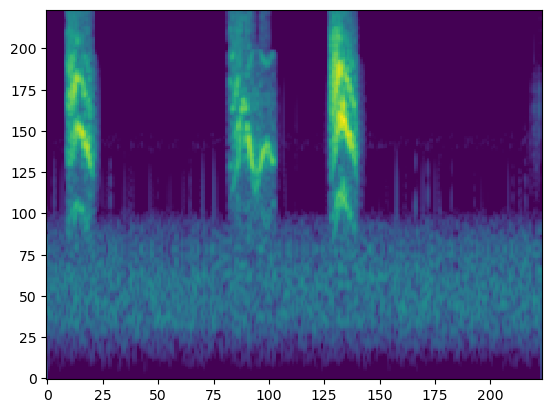

In [51]:
r = 'C:\\Users\\KB\\Documents\\ECE496_capstone\\venv\\Scripts\\birdclef-2022\\train_audio\\houspa\\XC124181.ogg'
print(r)
IPython.display.display(IPython.display.Audio(r, rate=32000))
y, sr = preprocess_one_audio(r)
IPython.display.display(IPython.display.Audio(y, rate=sr))
melspec = get_spectrogram(y)
print(melspec)
print(melspec.shape)
fig, (ax1) = plt.subplots(1,1)
ax1.imshow(librosa.power_to_db(melspec), origin="lower", aspect="auto", interpolation="nearest")

C:\Users\KB\Documents\ECE496_capstone\venv\Scripts\birdclef-2022\train_audio\houspa\XC139186.ogg


tensor([[1.9149e-04, 5.5383e-06, 8.8693e-10,  ..., 1.6038e-09, 6.2478e-08,
         2.1975e-06],
        [1.9369e-04, 5.7220e-06, 2.0643e-09,  ..., 2.6587e-09, 6.1518e-08,
         2.2844e-06],
        [1.9722e-04, 6.0161e-06, 3.9480e-09,  ..., 4.3465e-09, 5.9983e-08,
         2.4234e-06],
        ...,
        [2.1998e-03, 1.3895e-04, 1.9526e-04,  ..., 7.6475e-15, 2.3944e-10,
         7.6558e-09],
        [1.8786e-03, 1.5437e-04, 2.4108e-04,  ..., 5.8493e-15, 2.4089e-10,
         7.7019e-09],
        [1.6778e-03, 1.6400e-04, 2.6972e-04,  ..., 4.7254e-15, 2.4179e-10,
         7.7308e-09]])
torch.Size([224, 224])


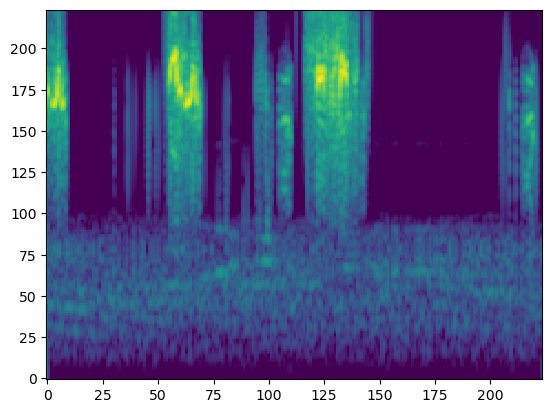

In [52]:
r = 'C:\\Users\\KB\\Documents\\ECE496_capstone\\venv\\Scripts\\birdclef-2022\\train_audio\\houspa\\XC139186.ogg'
print(r)
IPython.display.display(IPython.display.Audio(r, rate=32000))
y, sr = preprocess_one_audio(r)
IPython.display.display(IPython.display.Audio(y, rate=sr))
melspec = get_spectrogram(y)
print(melspec)
print(melspec.shape)
fig, (ax1) = plt.subplots(1,1)
ax1.imshow(librosa.power_to_db(melspec), origin="lower", aspect="auto", interpolation="nearest")

In [53]:
#Ensures equal amount of data per species in train, val, test set
def get_XY(start, end, num_of_species, species):
    #Array of tuples(X: melspec, Y: label of the bird, Z: Path of the rec for verification)
    X, Y, Z = [], [], []
    for i, specie in enumerate(species[:num_of_species]):
        recs = specie.recordings[start:end]
        for rec in recs:
            melspec = get_spectrogram(preprocess_one_audio(rec)[0])
            X.append(melspec)
            Y.append(i)
            # Y.append([i,int(rec.split('/')[-1].split('.')[0][2:])])
            Z.append(rec)
    return [torch.stack(X), torch.tensor(Y), Z]

def get_labelled_data(species, num_of_species=3, num_of_recs_per_species=72, split_train=0.8, split_val=0.1, split_test=0.1):
    data_train = get_XY(0, int(num_of_recs_per_species*split_train), num_of_species, species)
    data_val = get_XY(int(num_of_recs_per_species*split_train), int(num_of_recs_per_species*split_train + num_of_recs_per_species*split_val), num_of_species, species)
    data_test = get_XY(int(num_of_recs_per_species*split_train + num_of_recs_per_species*split_val), int(num_of_recs_per_species*split_train + num_of_recs_per_species*split_val + num_of_recs_per_species*split_test), num_of_species, species)
    return data_train, data_val, data_test

def save_labelled_data(train, val, test):
    X_train, Y_train = train[0], train[1]
    X_val, Y_val = val[0], val[1]
    X_test, Y_test = test[0], test[1]
    torch.save(X_train.clone().detach(), 'classifier_X_train.pt')
    torch.save(Y_train.clone().detach(), 'classifier_Y_train.pt')
    torch.save(X_val.clone().detach(), 'classifier_X_val.pt')
    torch.save(Y_val.clone().detach(), 'classifier_Y_val.pt')
    torch.save(X_test.clone().detach(), 'classifier_X_test.pt')
    torch.save(Y_test.clone().detach(), 'classifier_Y_test.pt')
    X_train, Y_train, X_val, Y_val, X_test, Y_test = None, None, None, None, None, None
    del X_train
    del Y_train
    del X_val
    del Y_val
    del X_test
    del Y_test

def retrieve_labelled_data():
    X_train, Y_train = torch.load('classifier_X_train.pt'), torch.load('classifier_Y_train.pt')
    X_val, Y_val = torch.load('classifier_X_val.pt'), torch.load('classifier_Y_val.pt')
    X_test, Y_test = torch.load('classifier_X_test.pt'), torch.load('classifier_Y_test.pt')
    return [X_train, Y_train], [X_val, Y_val], [X_test, Y_test]

def get_data_samplers(train, val, random_seed=1):
    #shuffle training, val data
    def shuffle_indices(indices):
        np.random.seed(random_seed)
        np.random.shuffle(indices)
        sampler = SubsetRandomSampler(indices)
        return sampler
    train_sampler = shuffle_indices(list(range(len(train[0]))))
    val_sampler = shuffle_indices(list(range(len(val[0]))))
    return train_sampler, val_sampler

In [54]:
###########Save tensors only if config better than num_of_species=2, num_of_recs_per_species=100###########
train, val, test = get_labelled_data(species)
save_labelled_data(train, val, test)
train1, val1, test1 = retrieve_labelled_data()
train_sampler, val_sampler= get_data_samplers(train1, val1)

In [55]:
class ClassifierDataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        super(ClassifierDataset, self).__init__()
        self.X = X
        self.Y = Y
        self.len = X.size(0)

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

classifier_train_dataset = ClassifierDataset(train1[0], train1[1])
classifier_val_dataset = ClassifierDataset(val1[0], val1[1])
classifier_test_dataset = ClassifierDataset(test1[0], test1[1])

In [56]:
batch_size = 10
train_loader = torch.utils.data.DataLoader(classifier_train_dataset, batch_size=batch_size, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(classifier_train_dataset, batch_size=batch_size, sampler=val_sampler)
test_loader = torch.utils.data.DataLoader(classifier_test_dataset, batch_size=batch_size)

In [57]:
#Defining the Classifier module
# class Classifier(nn.Module):

#     def __init__(self, n_classes):
#         super(Classifier, self).__init__()
#         self.n_classes = n_classes
#         self.lin_size = 64*32*200
#         self.blocks = nn.ModuleList([
#             nn.Sequential(
#                 # 1-2
#                 nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3), padding=1),
#                 nn.LeakyReLU(),
#                 nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3), padding=1),
#                 nn.LeakyReLU(),
#                 nn.MaxPool2d(kernel_size=(2,2)),
#             ),
#             nn.Sequential(
#                 # 3-4
#                 nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding=1),
#                 nn.LeakyReLU(),
#                 nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), padding=1),
#                 nn.LeakyReLU(),
#                 nn.MaxPool2d(kernel_size=(2,2)),
#                 nn.Dropout(0.5),
#             ),
#         ])
#         self.drop = nn.Dropout(0.5)
#         self.fc1 = nn.Linear(self.lin_size, 128)
#         self.fc2 = nn.Linear(128, n_classes)

#     def forward(self, x):
#         #conv block
#         for b in self.blocks:
#             x = b(x)
#         #lin blocks
#         x = x.view(-1, self.lin_size)
#         x = F.leaky_relu(self.fc1(x))
#         x = self.drop(x)
#         x = self.fc2(x)
#         return x

In [58]:
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
print('Number of features from pre-trained model', num_features)
# Add a fully-connected layer for classification
model.fc = nn.Linear(num_features, 3)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

Number of features from pre-trained model 512


c:\ProgramData\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [59]:
# model = Classifier(n_classes=3)
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

Epoch 1, Training Loss: 1.1056, Validation Loss: 1.2449
Epoch 2, Training Loss: 0.9695, Validation Loss: 0.8855
Epoch 3, Training Loss: 0.8468, Validation Loss: 0.7606
Epoch 4, Training Loss: 0.7679, Validation Loss: 0.7176
Epoch 5, Training Loss: 0.7414, Validation Loss: 0.6056
Epoch 6, Training Loss: 0.6848, Validation Loss: 0.3779
Epoch 7, Training Loss: 0.5929, Validation Loss: 0.3867
Epoch 8, Training Loss: 0.5679, Validation Loss: 0.2959
Epoch 9, Training Loss: 0.5242, Validation Loss: 0.2101
Epoch 10, Training Loss: 0.5480, Validation Loss: 0.3477
Epoch 11, Training Loss: 0.4784, Validation Loss: 0.2109
Epoch 12, Training Loss: 0.4007, Validation Loss: 0.2213
Epoch 13, Training Loss: 0.4526, Validation Loss: 0.2245
Epoch 14, Training Loss: 0.4286, Validation Loss: 0.2339
Epoch 15, Training Loss: 0.3614, Validation Loss: 0.1722
Epoch 16, Training Loss: 0.3727, Validation Loss: 0.2006
Epoch 17, Training Loss: 0.3635, Validation Loss: 0.1791
Epoch 18, Training Loss: 0.3542, Validat

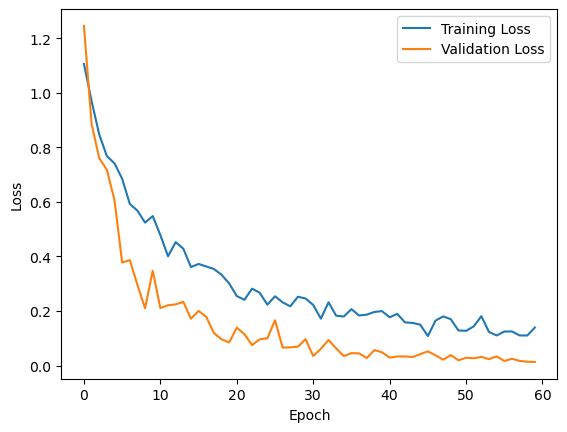

In [60]:
# train the network with low epochs
n_epoch = 60
train_losses = []
val_losses = []
for epoch in range(n_epoch):
    training_loss = 0.0
    model.train()
    for i, data in enumerate(train_loader):
        inputs, raw_labels = data[0].unsqueeze(dim=1), data[1]
        optimizer.zero_grad()
        inputs = torch.cat([inputs] * 3, dim=1)
        # print (inputs.shape)
        outputs = model(inputs)
        loss = criterion(outputs, raw_labels)
        loss.backward()
        optimizer.step()
        training_loss += loss.item()
    average_train_loss = training_loss / len(train_loader)
    train_losses.append(average_train_loss)

    validation_loss = 0.0
    model.eval()
    with torch.no_grad():
      for i, data in enumerate(val_loader):
        inputs, raw_labels = data[0].unsqueeze(dim=1), data[1]
        inputs = torch.cat([inputs] * 3, dim=1)
        outputs = model(inputs)
        loss = criterion(outputs, raw_labels)
        validation_loss += loss.item()
    average_val_loss = validation_loss / len(val_loader)
    val_losses.append(average_val_loss)

    print(f"Epoch {epoch + 1}, Training Loss: {average_train_loss:.4f}, Validation Loss: {average_val_loss:.4f}")
    torch.save(model, "firstModel.pth")

plt.figure()
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [61]:
#test accuracy
accuracy = 0.0
total = 0.0
loaded_model = torch.load("firstModel.pth")
loaded_model.eval()
with torch.no_grad():
    for i, data in enumerate(test_loader):
        inputs, raw_labels = data[0].unsqueeze(dim=1), data[1]
        inputs = torch.cat([inputs] * 3, dim=1)
        outputs = F.softmax(loaded_model(inputs), dim=1)
        print(outputs)
        _, predicted = torch.max(outputs, 1)
        total += raw_labels.size(0)
        accuracy += (predicted == raw_labels).sum().item()

accuracy = (100 * accuracy/total)
print(accuracy)

tensor([[9.9580e-01, 1.8380e-03, 2.3589e-03],
        [9.6676e-01, 4.2880e-03, 2.8956e-02],
        [9.7467e-01, 5.8442e-03, 1.9485e-02],
        [5.3692e-01, 4.5113e-01, 1.1945e-02],
        [9.9121e-01, 8.5568e-04, 7.9317e-03],
        [2.0079e-02, 9.5682e-01, 2.3102e-02],
        [9.7808e-01, 1.3796e-02, 8.1284e-03],
        [2.1844e-01, 7.5641e-01, 2.5149e-02],
        [1.8413e-03, 9.2356e-01, 7.4601e-02],
        [4.4393e-01, 4.3848e-01, 1.1759e-01]])
tensor([[3.6092e-04, 9.8753e-01, 1.2105e-02],
        [4.6882e-02, 8.4520e-01, 1.0792e-01],
        [4.7379e-02, 9.1505e-01, 3.7571e-02],
        [2.9913e-02, 5.1547e-01, 4.5461e-01],
        [9.1539e-01, 4.3801e-02, 4.0812e-02],
        [2.0860e-01, 6.0191e-01, 1.8949e-01],
        [2.2942e-01, 1.9070e-01, 5.7989e-01],
        [2.1801e-01, 3.1052e-02, 7.5094e-01],
        [5.0809e-03, 4.4167e-02, 9.5075e-01],
        [2.3618e-02, 2.4166e-01, 7.3472e-01]])
tensor([[5.3834e-03, 1.7069e-02, 9.7755e-01],
        [8.2940e-03, 1.3388e-01,